In [1]:
%matplotlib inline
import glob
import pandas as pd
import numpy as np
import datetime
import time

from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sqlalchemy import select

import boto3
from io import BytesIO, StringIO
from sagemaker import get_execution_role

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 500)
pd.set_option('display.multi_sparse', False)

#s3 connection
bucket='monit-data-bogo'
s3 = boto3.client('s3')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


If a new set of radar data files is generated, use next cell to consolidate them all. The set of radar data files is generated through the "scrape.py" and "clean_data.py" scripts 

In [2]:
def read_radar_files():
    %%time
    #Iterate over all s3 clean data objects
    all_clean_files = []
    df_radar = pd.DataFrame()
    paginator = s3.get_paginator('list_objects')
    page_iterator = paginator.paginate(Bucket=bucket, Prefix="clean/")
    for page in page_iterator:
        all_clean_files += [c["Key"] for c in page["Contents"]]

    for file in all_clean_files:
        obj = s3.get_object(Bucket=bucket, Key=file)
        temp_df = pd.read_excel(BytesIO(obj['Body'].read()))
        df_radar = df_radar.append(temp_df)
        
    return df_radar

#df_radar = read_radar_files()

#Save to s3 bucket
# key = "clean_aggregated.csv"
# csv_buffer = StringIO()
# df_radar.to_csv(csv_buffer)
# s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket, Key=key)
    
# display(df_radar.head())

In case data has already been consolidated by the cell above, simply read the data with cell below.

In [3]:
def read_aggregated_file():
    obj = s3.get_object(Bucket=bucket, Key='processed/clean_aggregated.csv')
    df_radar = pd.read_csv(BytesIO(obj['Body'].read()),
                           index_col=0,
                           dtype={"Corredor": object,
                                  "Ciclofaixa": object,
                                  "Numero de faixas": object})

    return df_radar

df_radar = read_aggregated_file()
display(df_radar.shape)
df_radar.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1486080, 22)

,Endereco,Corredor,Ciclofaixa,Numero de faixas,Latitude,Longitude,Sentido,Data,Equipamento,Horario,00 a 10,11 a 20,21 a 30,31 a 40,41 a 50,51 a 60,61 a 70,71 a 80,81 a 90,91 a 100,Acima de 100,Total
0,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,00:00 as 00:14,0,1,1,4,8,1,0,0,0,0,0,15
1,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,00:15 as 00:29,0,0,1,10,6,0,0,0,0,0,0,17
2,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,00:30 as 00:44,0,0,0,1,6,2,0,1,0,0,0,10
3,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,00:45 as 00:59,0,0,2,6,6,1,0,0,0,0,0,15
4,Rua Areia Branca. 681,0,0,1,-26.26574,-48.80091,L/O,2017-09-01,FS551JOI,01:00 as 01:14,0,0,0,1,1,0,0,0,0,0,0,2


Some basic data cleaning:

In [4]:
#Sum flows counted separately in Template 3
df_radar_clean = df_radar.groupby(["Endereco",
                                   "Sentido",
                                   "Data",
                                   "Equipamento",
                                   "Horario",
                                  ]).agg('sum')

display(df_radar.shape)
display(df_radar_clean.shape)
df_radar_clean.reset_index(inplace=True)

#Join with manual data enrichment
obj = s3.get_object(Bucket=bucket, Key='external/FluxoVelocidadePorMinutoSentido_latest.xlsx')
man_enrich = pd.read_excel(BytesIO(obj['Body'].read()))
man_enrich.set_index("Equipamento", inplace=True, verify_integrity=True)
man_enrich.columns = man_enrich.columns.str.strip() 
man_enrich = man_enrich[["Latitude", "Longitude", "Corredor", "Ciclofaixa", "Estacionamento", "Numero de Faixas"]]

df_radar_clean = df_radar_clean.join(man_enrich, on="Equipamento", lsuffix="_ignore")
keep_cols = [c for c in df_radar_clean.columns.tolist() if "_ignore" not in c]
df_radar_clean = df_radar_clean[keep_cols]

#Fill na values on manually filled cells
df_radar_clean[["Corredor",
                "Ciclofaixa",
                "Numero de Faixas"]] = df_radar_clean[["Corredor",
                                                       "Ciclofaixa",
                                                       "Numero de Faixas"]].replace("-", np.nan)

#Convert date df_radar["Data"], format="%Y-%m-%d" to datetime
df_radar_clean["Data"] = pd.to_datetime(df_radar_clean["Data"], format="%Y-%m-%d")
df_radar_clean["hour"] = df_radar_clean["Horario"].str[:2]

#Convert number of lanes to int
df_radar_clean["Numero de Faixas"] = df_radar_clean["Numero de Faixas"].astype(float)

#Let's correct errors manually and automate it later via a join with the spreadsheet.
#Expedicionário Holz is the only street that has different number of lanes in different directions.
mask = (df_radar_clean["Equipamento"] ==  "FS621JOI") & (df_radar_clean["Sentido"] ==  "Norte/Sul")
df_radar_clean.loc[mask, "Numero de Faixas"] = 1

#Drop Equipments with zero count in most days during the period (unreliable equipment)
count_per_day = df_radar_clean.groupby(["Data", "Endereco", "Sentido", "Equipamento"]).agg({"Total": sum}).reset_index() #get total count per day
median_per_equip = count_per_day.groupby(["Endereco", "Sentido", "Equipamento"]).agg({"Total": 'median'}).reset_index()
fail_equip_series = median_per_equip[median_per_equip["Total"] == 0]["Equipamento"].unique()
df_radar_clean = df_radar_clean[~df_radar_clean["Equipamento"].isin(fail_equip_series)]
df_radar_clean.head(1)


(1486080, 22)

(1474560, 14)

,Endereco,Sentido,Data,Equipamento,Horario,00 a 10,11 a 20,21 a 30,31 a 40,41 a 50,51 a 60,61 a 70,71 a 80,81 a 90,91 a 100,Acima de 100,Total,Latitude,Longitude,Corredor,Ciclofaixa,Estacionamento,Numero de Faixas,hour
0,Av. Aluisio Pires Condeixa. 2700,Sul/Norte,2017-09-01,FS593JOI,00:00 as 00:14,0,0,0,5,16,7,0,0,0,0,0,28,-26.2792,-48.8462,0.0,0.0,1,2.0,00


No drastic change in traffic flow in peak hours, across DST change day. We will assume DST is being taken into account by the data.

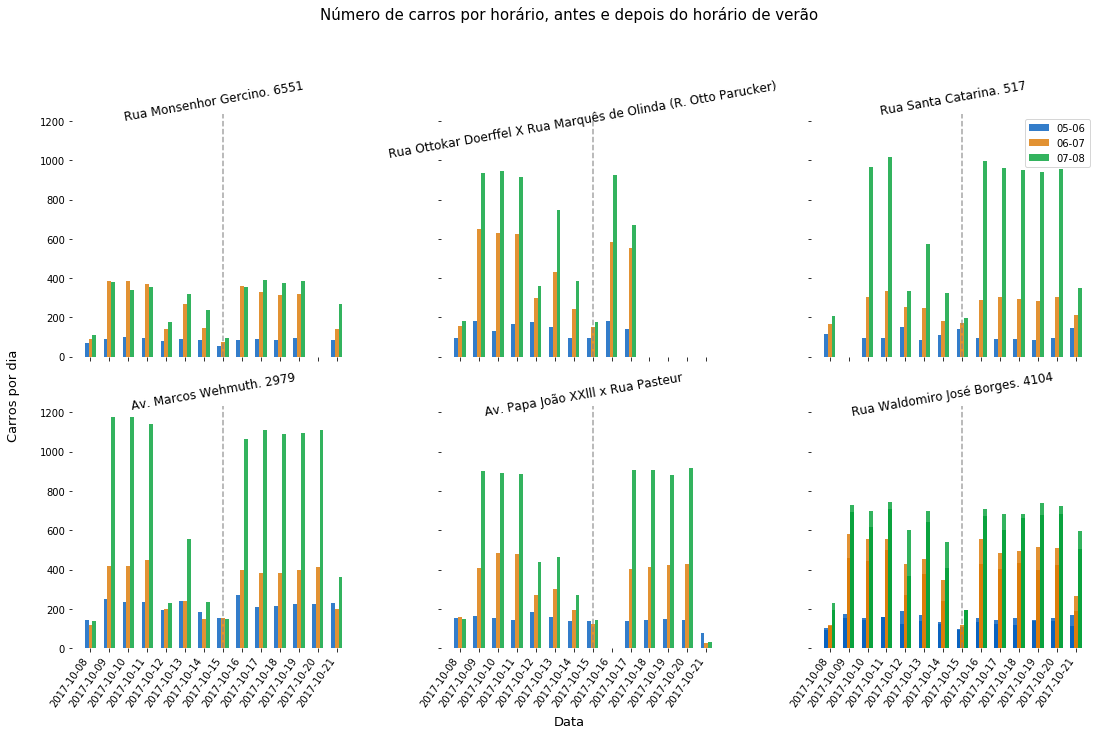

In [5]:
# Check behavior of Daylight Saving time
before_dsl = datetime.date(year=2017, month=10, day=8)
after_dsl = datetime.date(year=2017, month=10, day=21)
hour_1 = "05"
hour_2 = "06"
hour_3 = "07"
hour_4 = str(int(hour_3)+1).zfill(2) #for labels only

dst_check = df_radar_clean[((df_radar_clean["Data"] >= before_dsl) & (df_radar_clean["Data"] <= after_dsl)) & \
                            (df_radar_clean["hour"].isin([hour_1, hour_2, hour_3]))
                          ].groupby(["Endereco", "Sentido", "Data", "Equipamento", "hour"]) \
                           .agg({"Total": sum}) \
                           .unstack(level=-1) \
                           .reset_index(["Endereco", "Sentido", "Equipamento"])
            
equip_list = np.random.choice(dst_check["Equipamento"].unique(), replace=False, size=6)
                                       
#Plotting
fig = plt.figure()

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,9))

e = 0
for i in range(0,2):
    for j in range(0,3):
        data = dst_check[dst_check["Equipamento"] == equip_list[e]]
        x = mdates.date2num(data.index.date)
        y1 = data[('Total', hour_1)]
        y2 = data[('Total', hour_2)]
        y3 = data[('Total', hour_3)]
        e += 1
        width=0.2
        ax[i][j].bar(x-width, y1, width=width, align='center', color="#005DBD", alpha=0.8, label=hour_1+"-"+hour_2)
        ax[i][j].bar(x, y2, width, align='center',color="#DB7700", alpha=0.8, label=hour_2+"-"+hour_3)
        ax[i][j].bar(x+width, y3, width, align='center', color="#00A036", alpha=0.8, label=hour_3+"-"+hour_4)
        
        if i == 1:
            days = mdates.DayLocator()   # every day
            days_format = mdates.DateFormatter('%Y-%m-%d')
            ax[i][j].xaxis.set_major_locator(days)
            ax[i][j].xaxis.set_major_formatter(days_format)

        # Hide the right and top spines
        ax[i][j].spines['left'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['bottom'].set_visible(False)

        #Vertical line
        ax[i][j].axvline(datetime.date(2017, 10, 15), alpha=0.7, linestyle='dashed', color="gray")
        
        #Street name
        ax[i][j].set_title(data["Endereco"].iloc[0], rotation=10, y=1.08)
    


fig.autofmt_xdate(rotation=55)
fig.suptitle("Número de carros por horário, antes e depois do horário de verão", fontsize=15, y=1.1)
fig.text(-0.02, 0.5, "Carros por dia", va='center', rotation='vertical', fontsize=13)
fig.text(0.5, -0.01, "Data", ha='center', fontsize=13)
ax[0][2].legend()
fig.tight_layout()

Below we prepare the calculation of the arithmetic speed average for each data point. 

In [6]:
def weighted_sum_speed(x, avg_speeds):
    weighted_sum = 0
    for spd in avg_speeds:
        weighted_sum += x[spd]*avg_speeds[spd]
   
    return weighted_sum

avg_speeds = {"00 a 10": 5,
            "11 a 20": 15,
            "21 a 30": 25,
            "31 a 40": 35,
            "41 a 50": 45,
            "51 a 60": 55,
            "61 a 70": 65,
            "71 a 80": 75,
            "81 a 90": 85,
            "91 a 100": 95,
            "Acima de 100": 105}

df_radar_clean["weighted_sum_speed"] = df_radar_clean.apply(lambda x: weighted_sum_speed(x, avg_speeds), axis=1)
df_radar_clean.head(1)

,Endereco,Sentido,Data,Equipamento,Horario,00 a 10,11 a 20,21 a 30,31 a 40,41 a 50,51 a 60,61 a 70,71 a 80,81 a 90,91 a 100,Acima de 100,Total,Latitude,Longitude,Corredor,Ciclofaixa,Estacionamento,Numero de Faixas,hour,weighted_sum_speed
0,Av. Aluisio Pires Condeixa. 2700,Sul/Norte,2017-09-01,FS593JOI,00:00 as 00:14,0,0,0,5,16,7,0,0,0,0,0,28,-26.2792,-48.8462,0.0,0.0,1,2.0,00,1280


In [7]:
count_per_hour = df_radar_clean.groupby(["Endereco", "Data",
                                         "Sentido", "Equipamento", "hour",
                                         "Latitude", "Longitude", "Numero de Faixas", "Corredor",
                                        ]).agg({"Total": sum,
                                                "weighted_sum_speed": sum})
count_per_hour.reset_index(inplace=True)
count_per_hour["weighted_avg_speed"] = count_per_hour["weighted_sum_speed"] / count_per_hour["Total"]
count_per_hour["total_por_faixa"] = count_per_hour["Total"]/count_per_hour["Numero de Faixas"]

#Median automatically take care of outliers in both sides
avg_count_per_hour = count_per_hour.groupby(by=["Endereco", "Sentido", "Equipamento",
                                                "hour", "Latitude", "Longitude",
                                                "Numero de Faixas", "Corredor",]).agg({"Total": 'median',
                                                                                       "total_por_faixa": 'median',
                                                                                       "weighted_avg_speed": 'median'})
avg_count_per_hour.reset_index(inplace=True)
avg_count_per_hour.sort_values("total_por_faixa", ascending=False, inplace=True)
avg_count_per_hour

,Endereco,Sentido,Equipamento,hour,Latitude,Longitude,Numero de Faixas,Corredor,Total,total_por_faixa,weighted_avg_speed
425,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,17,-26.2998,-48.8424,2.0,1.0,2090.5,1045.250000,27.400747
421,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,13,-26.2998,-48.8424,2.0,1.0,1963.0,981.500000,28.234317
422,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,14,-26.2998,-48.8424,2.0,1.0,1954.0,977.000000,27.134591
426,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,18,-26.2998,-48.8424,2.0,1.0,1946.0,973.000000,27.032258
423,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,15,-26.2998,-48.8424,2.0,1.0,1944.0,972.000000,27.416184
415,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,07,-26.2998,-48.8424,2.0,1.0,1892.0,946.000000,27.883342
2538,Rua Tenente Antônio João. 1937,S/N,FS643JOI,18,-26.2596,-48.8465,2.0,0.0,1879.5,939.750000,41.787430
416,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,08,-26.2998,-48.8424,2.0,1.0,1874.5,937.250000,27.648377
424,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,16,-26.2998,-48.8424,2.0,1.0,1874.5,937.250000,27.737527
1663,Rua Iririu. 1070,N/S,FS579JOI,07,-26.276,-48.8342,2.0,0.0,1799.5,899.750000,43.436533


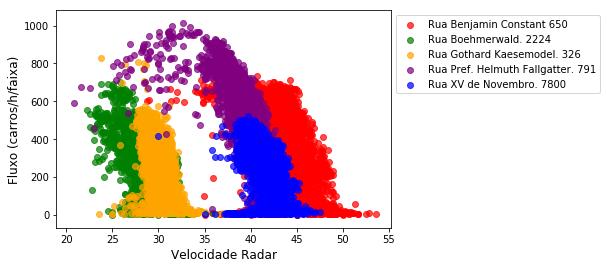

In [8]:
fig, ax = plt.subplots()

equip_list = np.random.choice(count_per_hour["Equipamento"].unique(), replace=False, size=5)

equip_data1 = count_per_hour[(count_per_hour["Equipamento"]==equip_list[0])]
ax.scatter(equip_data1["weighted_avg_speed"],
           equip_data1["total_por_faixa"],
           label=equip_data1["Endereco"].iloc[0],
           color='red',
           alpha=0.7)

equip_data2 = count_per_hour[(count_per_hour["Equipamento"]==equip_list[1])]
ax.scatter(equip_data2["weighted_avg_speed"],
            equip_data2["total_por_faixa"],
            label=equip_data2["Endereco"].iloc[0],
            color='green',
            alpha=0.7)

equip_data3 = count_per_hour[(count_per_hour["Equipamento"]==equip_list[2])]
ax.scatter(equip_data3["weighted_avg_speed"],
            equip_data3["total_por_faixa"],
            label=equip_data3["Endereco"].iloc[0],
            color='orange',
            alpha=0.7)

equip_data4 = count_per_hour[(count_per_hour["Equipamento"]==equip_list[3])]
ax.scatter(equip_data4["weighted_avg_speed"],
           equip_data4["total_por_faixa"],
           label=equip_data4["Endereco"].iloc[0],
           color='purple',
           alpha=0.7)

equip_data5 = count_per_hour[(count_per_hour["Equipamento"]==equip_list[4])]
ax.scatter(equip_data5["weighted_avg_speed"],
           equip_data5["total_por_faixa"],
           label=equip_data5["Endereco"].iloc[0],
           color='blue',
           alpha=0.7)

plt.xlabel("Velocidade Radar", fontsize=12)
plt.ylabel("Fluxo (carros/h/faixa)", fontsize=12)
ax.legend(bbox_to_anchor=(1, 1))
sns.set_style("whitegrid")

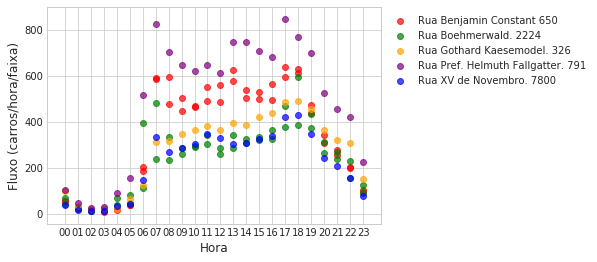

In [9]:
fig_2 = plt.figure(2)
hourplot = fig_2.subplots()

avg_equip_data1 = avg_count_per_hour[(avg_count_per_hour["Equipamento"]==equip_list[0])]
hourplot.scatter(avg_equip_data1["hour"],
           avg_equip_data1["total_por_faixa"],
           label=avg_equip_data1["Endereco"].iloc[0],
           color='red',
           alpha=0.7)

avg_equip_data2 = avg_count_per_hour[(avg_count_per_hour["Equipamento"]==equip_list[1])]
hourplot.scatter(avg_equip_data2["hour"],
            avg_equip_data2["total_por_faixa"],
            label=avg_equip_data2["Endereco"].iloc[0],
            color='green',
            alpha=0.7)

avg_equip_data3 = avg_count_per_hour[(avg_count_per_hour["Equipamento"]==equip_list[2])]
hourplot.scatter(avg_equip_data3["hour"],
            avg_equip_data3["total_por_faixa"],
            label=avg_equip_data3["Endereco"].iloc[0],
            color='orange',
            alpha=0.7)

avg_equip_data4 = avg_count_per_hour[(avg_count_per_hour["Equipamento"]==equip_list[3])]
hourplot.scatter(avg_equip_data4["hour"],
           avg_equip_data4["total_por_faixa"],
           label=avg_equip_data4["Endereco"].iloc[0],
           color='purple',
           alpha=0.7)

avg_equip_data5 = avg_count_per_hour[(avg_count_per_hour["Equipamento"]==equip_list[4])]
hourplot.scatter(avg_equip_data5["hour"],
           avg_equip_data5["total_por_faixa"],
           label=avg_equip_data5["Endereco"].iloc[0],
           color='blue',
           alpha=0.7)

plt.xlabel("Hora", fontsize=12)
plt.ylabel("Fluxo (carros/hora/faixa)", fontsize=12)
hourplot.legend(bbox_to_anchor=(1, 1))
sns.set_style("whitegrid")


Save to s3 bucket:

In [10]:
avg_per_quarter = df_radar_clean
avg_per_quarter["weighted_avg_speed"] = avg_per_quarter["weighted_sum_speed"] / avg_per_quarter["Total"]
avg_per_quarter["total_por_faixa"] = avg_per_quarter["Total"]/avg_per_quarter["Numero de Faixas"]

#Median automatically take care of outliers in both sides
avg_per_quarter = avg_per_quarter.groupby(by=["Endereco", "Sentido", "Equipamento",
                                              "Latitude", "Longitude", "Horario",
                                              "Numero de Faixas", "Corredor",]).agg({"Total": 'median',
                                                                                       "total_por_faixa": 'median',
                                                                                       "weighted_avg_speed": 'median'})
avg_per_quarter.reset_index(inplace=True)
avg_per_quarter.sort_values("total_por_faixa", ascending=False, inplace=True)

avg_per_quarter_815 = avg_per_quarter[avg_per_quarter["Horario"] == "08:00 as 08:14" ]

avg_per_quarter_815.shape

(124, 11)

In [11]:
key = "avg_per_quarter.csv"
csv_buffer = StringIO()
avg_per_quarter.to_csv(csv_buffer)
#s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket, Key=key)